In [1]:
from typing import Literal

import os
import torch
import tqdm
import numpy as np

from torch import optim, nn, Tensor
from torch.utils.data import Dataset, DataLoader

from bert import BertForClassification

In [2]:
DATABASE_PATH = "./aclImdb"
EPOCH = 20
MAX_POSITION_EMBEDDINGS = 256

device = torch.device("cuda" if torch.cuda.is_available() else "mps")

In [3]:
from datasets import load_dataset

dataset = load_dataset("imdb")
dataset["train"].features

Found cached dataset imdb (/Users/louiechou/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

In [3]:
from transformers import BertTokenizerFast

tokenizer: BertTokenizerFast = BertTokenizerFast.from_pretrained("bert-base-uncased")


def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=MAX_POSITION_EMBEDDINGS,
    )

In [ ]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text", "token_type_ids"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [5]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Loading cached shuffled indices for dataset at /Users/louiechou/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c0cbb36c31d07142.arrow


In [6]:
bert = BertForClassification(
    vocab_size=tokenizer.vocab_size,
    d_model=768,
    intermediate_size=4 * 768,
    max_position_embeddings=MAX_POSITION_EMBEDDINGS,
    num_attention_heads=8,
    hidden_dropout_prob=0.1,
    num_hidden_layers=12,
    num_labels=2,
).to(device)

  5%|▌         | 313/6260 [07:01<1:59:08,  1.20s/it]

Epoch: 0 Loss: 0.7084238283550397


 10%|█         | 626/6260 [14:02<1:49:42,  1.17s/it]

Epoch: 1 Loss: 0.6980102007000591


 15%|█▌        | 939/6260 [21:05<1:44:26,  1.18s/it]

Epoch: 2 Loss: 0.6974823400616265


 20%|██        | 1252/6260 [27:57<1:34:54,  1.14s/it]

Epoch: 3 Loss: 0.700809410585763


 25%|██▌       | 1565/6260 [34:48<1:29:13,  1.14s/it]

Epoch: 4 Loss: 0.6867835493133472


 30%|███       | 1878/6260 [41:47<1:25:50,  1.18s/it]

Epoch: 5 Loss: 0.6296172269617026


 35%|███▌      | 2191/6260 [48:47<1:17:36,  1.14s/it]

Epoch: 6 Loss: 0.6023663908909684


 40%|████      | 2504/6260 [55:44<1:12:44,  1.16s/it]

Epoch: 7 Loss: 0.5633647015300421


 45%|████▌     | 2817/6260 [1:02:41<1:06:26,  1.16s/it]

Epoch: 8 Loss: 0.5180182480297911


 50%|█████     | 3130/6260 [1:09:40<1:00:49,  1.17s/it]

Epoch: 9 Loss: 0.4727749371776185


 55%|█████▌    | 3443/6260 [1:16:41<54:39,  1.16s/it]  

Epoch: 10 Loss: 0.43557149671708434


 60%|██████    | 3756/6260 [1:23:41<48:43,  1.17s/it]  

Epoch: 11 Loss: 0.3926134033801076


 65%|██████▌   | 4069/6260 [1:30:43<42:50,  1.17s/it]

Epoch: 12 Loss: 0.3447223226673687


 70%|███████   | 4382/6260 [1:37:43<36:14,  1.16s/it]

Epoch: 13 Loss: 0.3158498880819391


 75%|███████▌  | 4695/6260 [1:44:42<30:23,  1.17s/it]

Epoch: 14 Loss: 0.2691960035921476


 80%|████████  | 5008/6260 [1:51:42<24:21,  1.17s/it]

Epoch: 15 Loss: 0.23678437493051202


 85%|████████▌ | 5321/6260 [1:58:41<18:13,  1.16s/it]

Epoch: 16 Loss: 0.2190289359135083


 90%|█████████ | 5634/6260 [2:05:37<12:05,  1.16s/it]

Epoch: 17 Loss: 0.17837172868057563


 95%|█████████▌| 5947/6260 [2:12:35<06:05,  1.17s/it]

Epoch: 18 Loss: 0.15712444418475938


100%|██████████| 6260/6260 [2:19:37<00:00,  1.34s/it]


Epoch: 19 Loss: 0.13926980988503382


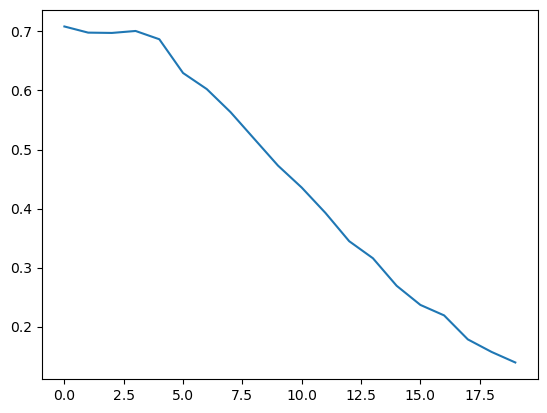

In [7]:
from transformers import get_scheduler

train_dataloader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)
optimizer = optim.Adam(bert.parameters(), lr=1e-5)
# lr_scheduler = get_scheduler(
#     name="linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=len(train_dataloader) * EPOCH,
# )

bert.train()
losses = []

with tqdm.tqdm(total=len(train_dataloader) * EPOCH) as tqdm_bar:
    for epoch in range(EPOCH):
        training_loss = 0.0
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            batch["input_ids"].transpose_(0, 1)
            # batch["attention_mask"].transpose_(0, 1)
            batch["attention_mask"] = batch["attention_mask"].to(dtype=torch.float32)
            loss, logits = bert(**batch)
            loss: Tensor
            loss.backward()
            training_loss += loss.item()
            optimizer.step()
            optimizer.zero_grad()
            tqdm_bar.update(1)
        print("Epoch:", epoch, "Loss:", training_loss / len(train_dataloader))
        losses.append(training_loss / len(train_dataloader))

import matplotlib.pyplot as plt

plt.plot(losses)

In [ ]:
torch.save(bert.state_dict(), "bert_from_scratch.pt")

In [9]:
bert.load_state_dict(
    torch.load("bert_from_scratch.pt", map_location=torch.device(device))
)

bert.to(device)

import evaluate

metric = evaluate.load("accuracy")

bert.eval()
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8, shuffle=True)
with tqdm.tqdm(eval_dataloader) as tqdm_bar:
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        batch["input_ids"].transpose_(0, 1)
        batch["attention_mask"] = batch["attention_mask"].to(dtype=torch.float32)

        with torch.no_grad():
            _, logits = bert(**batch)
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
        tqdm_bar.update(1)

metric.compute()

100%|██████████| 125/125 [00:26<00:00,  4.78it/s]


{'accuracy': 0.684}

In [4]:
bert = BertForClassification(
    vocab_size=tokenizer.vocab_size,
    d_model=768,
    intermediate_size=4 * 768,
    max_position_embeddings=MAX_POSITION_EMBEDDINGS,
    num_attention_heads=8,
    hidden_dropout_prob=0.1,
    num_hidden_layers=12,
    num_labels=2,
    output_attentions=True,
)

In [5]:
bert.load_state_dict(
    torch.load("bert_from_scratch.pt", map_location=torch.device('cpu'))
)

from bertviz import head_view, model_view

input_text = "The sign of a good movie is that it can toy with our emotions"
inputs = tokenizer.encode(input_text, return_tensors="pt")

# inputs = {k: v.to(device) for k, v in inputs.items()}
# inputs["input_ids"].transpose_(0, 1)
# inputs["attention_mask"] = inputs["attention_mask"].to(dtype=torch.float32)

loss, logits, attentions = bert(input_ids=inputs.transpose_(0, 1), labels=torch.tensor([1]))

tokens = tokenizer.convert_ids_to_tokens(inputs)
model_view(attentions, tokens)

<IPython.core.display.Javascript object>